# Exploratory Data Analysis Demo 

- Alejandro Hohmann
- Bhanu Muvva
- Chunxia Tong

The purpose of this notebook is to examine the data used in the Staley et al (ST16) model and to recreate their debris flow risk prediction model.

# Table of Contents

### - [EDA](#EDA)
### - [Logistic Regression](#LR)

In [1]:
# file structure libraries
import pandas as pd
#import os
import requests
from os.path import basename, join


# visualization libraries
from matplotlib import pyplot as plt
# Have plots display in notebook
%matplotlib inline
import seaborn as sns

# ML libraries
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


# for sigmoid function, in case we need to manually implement in LR
from scipy.stats import logistic

In [2]:
# assign seed now for consistency any time it needs to be used
seed=27

## The Staley et al. (2016) model report and data 
https://pubs.er.usgs.gov/publication/ofr20161106

## Read in and Examine Staley Raw Data <a id="EDA">

Download Staley et al. (2016) dataset:

In [3]:
url="https://pubs.usgs.gov/of/2016/1106/ofr20161106_appx-1.xlsx"
xlsfile=basename(url)

Download and save the data:

In [4]:
with open(join("../../data/", xlsfile),"wb") as fid:
    fid.write(requests.get(url).content)

Read data into memory:

In [5]:
file = "../../data/ofr20161106_appx-1.xlsx"
xl = pd.ExcelFile(file)
sheets = xl.sheet_names  # see all sheet names
sheets

['DataDescription', 'Appendix1_ModelData']

In [6]:
# can be helpful for reference
data_dict = pd.read_excel(file, sheet_name=sheets[0])

dict_cols = data_dict.columns

data_dict.sort_values(by=dict_cols[0])

U.S. Geological Survey Open-File Report 2016-1106  \
28                                          Acc015_mm   
29                                          Acc030_mm   
30                                          Acc060_mm   
0   Appendix 1. Data supporting logistic regressio...   
3                                       Column Header   
24                               ContributingArea_km2   
8                                            Database   
4                                           Fire Name   
6                                             Fire_ID   
7                                          Fire_SegID   
15                                        GaugeDist_m   
27                                                 KF   
21                                      Peak_I15_mm/h   
22                                      Peak_I30_mm/h   
23                                      Peak_I60_mm/h   
25                                           PropHM23   
13                                           Response   
9                                               State   
19                                      StormAccum_mm   
20                                     StormAvgI_mm/h   
14                                          StormDate   
18                                         StormDur_H   
17                                           StormEnd   
16                                         StormStart   
11                                              UTM_X   
12                                              UTM_Y   
10                                           UTM_Zone   
5                                                Year   
1   [ID, identifier (in heading); UTM, Universal T...   
26                                          dNBR/1000   
2                                                 NaN   

                                           Unnamed: 1  
28  Peak 15-minute rainfall accumulation of storm,...  
29  Peak 30-minute rainfall accumulation of storm,...  
30  Peak 60-minute rainfall accumulation of storm,...  
0                                                 NaN  
3                                         Description  
24  Contributing area of observation location, in ...  
8   Database type: “Training” indicates data used ...  
4                                    Name of wildfire  
6                           Abbreviation of fire name  
7   Concatenated fire abbreviation and unique segm...  
15  Distance (in meters) from rain gauge to docume...  
27  Average KF-Factor (erodibility index of the fi...  
21  Peak 15-minute rainfall intensity of storm, in...  
22  Peak 30-minute rainfall intensity of storm, in...  
23  Peak 60-minute rainfall intensity of storm, in...  
25  Proportion of watershed burned at high or mode...  
13  Field-verified hydrologic response.  0 = no de...  
9                    State in which wildfire occurred  
19  Total rainfall accumulation of storm, in milli...  
20  Average storm intensity, in milllimeters per hour  
14  Date of storm that produced the debris-flow re...  
18                  Total duration of storm, in hours  
17  Date and time (24-hour format, GMT) that storm...  
16  Date and time (24-hour format, GMT) that storm...  
11  UTM X coordinate (Easting, in meters from zone...  
12  UTM Y coordinate (Northing, in meters from zon...  
10      UTM zone containing majority of wildfire area  
5                         Year of wildfire occurrence  
1                                                 NaN  
26  Average differenced normalized burn ratio (dNB...  
2                                                 NaN

In [7]:
raw_data = pd.read_excel(file, sheet_name=sheets[1])
raw_data.head()

Fire Name  Year Fire_ID Fire_SegID  Database State  UTM_Zone        UTM_X  \
0  Buckweed  2007     bck   bck_1035  Training    CA        11  368133.5165   
1  Buckweed  2007     bck   bck_1090  Training    CA        11  367871.0165   
2  Buckweed  2007     bck   bck_1570  Training    CA        11  367503.5165   
3  Buckweed  2007     bck    bck_235  Training    CA        11  371108.5165   
4  Buckweed  2007     bck    bck_363  Training    CA        11  370763.5165   

         UTM_Y  Response  ... Peak_I15_mm/h  Peak_I30_mm/h Peak_I60_mm/h  \
0  3823231.989         0  ...           3.2            2.0           2.0   
1  3822984.489         0  ...           3.2            2.0           2.0   
2  3821741.989         0  ...           3.2            2.0           2.0   
3  3824991.989         0  ...           1.6            1.2           0.8   
4  3824576.989         0  ...           1.6            1.2           0.8   

  ContributingArea_km2  PropHM23  dNBR/1000        KF  Acc015_mm  Acc030_mm  \
0             0.378767  0.217933   0.297853  0.250000        0.8        1.0   
1             0.689615  0.061249   0.224896  0.250000        0.8        1.0   
2             2.757312  0.042968   0.065537  0.248541        0.8        1.0   
3             0.613415  0.092164   0.141711  0.250000        0.4        0.6   
4             0.538875  0.058353   0.210158  0.250000        0.4        0.6   

   Acc060_mm  
0        2.0  
1        2.0  
2        2.0  
3        0.8  
4        0.8  

[5 rows x 27 columns]

In [8]:
raw_data['State'].value_counts()

CA    939
CO    300
AZ    209
NM     58
MT     26
ID     14
UT      4
Name: State, dtype: int64

In [9]:
raw_data['Database'].value_counts()

Training    939
Test        611
Name: Database, dtype: int64

In [10]:
raw_data.shape

(1550, 27)

In [11]:
raw_data.describe().T

count          mean            std           min  \
Year                  1550.0  2.006934e+03       3.466538  2.000000e+03   
UTM_Zone              1550.0  1.161613e+01       0.836003  1.100000e+01   
UTM_X                 1550.0  4.039920e+05   88105.486725  2.352828e+05   
UTM_Y                 1550.0  3.926658e+06  306377.242095  3.468148e+06   
Response              1550.0  2.154839e-01       0.411290  0.000000e+00   
GaugeDist_m           1550.0  1.958996e+03    1071.810282  2.784397e+01   
StormDur_H            1550.0  1.844601e+01      18.507975  0.000000e+00   
StormAccum_mm         1550.0  3.497151e+01      38.374910  0.000000e+00   
StormAvgI_mm/h        1550.0  4.877449e+00       9.364335  0.000000e+00   
Peak_I15_mm/h         1320.0  2.382132e+01      21.259860  1.600000e+00   
Peak_I30_mm/h         1336.0  1.697799e+01      14.776918  1.200000e+00   
Peak_I60_mm/h         1294.0  1.081554e+01       8.453919  6.000000e-01   
ContributingArea_km2  1550.0  1.047743e+00       1.537803  2.010000e-02   
PropHM23              1550.0  4.787133e-01       0.276017  0.000000e+00   
dNBR/1000             1473.0  3.403182e-01       0.189386  7.158207e-03   
KF                    1550.0  2.330627e-01       0.427766  0.000000e+00   
Acc015_mm             1320.0  5.955329e+00       5.314965  4.000000e-01   
Acc030_mm             1336.0  8.488994e+00       7.388459  6.000000e-01   
Acc060_mm             1294.0  1.081554e+01       8.453919  6.000000e-01   

                               25%           50%           75%           max  
Year                  2.003000e+03  2.009000e+03  2.009000e+03  2.012000e+03  
UTM_Zone              1.100000e+01  1.100000e+01  1.200000e+01  1.300000e+01  
UTM_X                 3.699579e+05  3.920590e+05  4.443863e+05  7.335575e+05  
UTM_Y                 3.787834e+06  3.795699e+06  3.908735e+06  5.110116e+06  
Response              0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00  
GaugeDist_m           1.037460e+03  1.913675e+03  2.811028e+03  3.999300e+03  
StormDur_H            2.000000e+00  1.430000e+01  2.713750e+01  6.500000e+01  
StormAccum_mm         8.380000e+00  2.200000e+01  5.120000e+01  2.222500e+02  
StormAvgI_mm/h        6.157580e-01  1.960000e+00  4.237463e+00  5.867014e+01  
Peak_I15_mm/h         1.040000e+01  1.680000e+01  2.757400e+01  1.120000e+02  
Peak_I30_mm/h         8.128000e+00  1.200000e+01  2.050000e+01  8.000000e+01  
Peak_I60_mm/h         5.350500e+00  8.380000e+00  1.298850e+01  5.080000e+01  
ContributingArea_km2  1.084853e-01  4.359857e-01  1.308229e+00  7.888105e+00  
PropHM23              2.334469e-01  5.232881e-01  6.924057e-01  9.895255e-01  
dNBR/1000             1.934882e-01  3.114808e-01  4.615503e-01  9.974387e-01  
KF                    1.500001e-01  2.393612e-01  2.600000e-01  1.136042e+01  
Acc015_mm             2.600000e+00  4.200000e+00  6.893500e+00  2.800000e+01  
Acc030_mm             4.064000e+00  6.000000e+00  1.025000e+01  4.000000e+01  
Acc060_mm             5.350500e+00  8.380000e+00  1.298850e+01  5.080000e+01

## Handling Missing Values

### Determine features with missing values

In [12]:
print("NAs for each feature:")
raw_data.isna().sum()

NAs for each feature:


Fire Name                 0
Year                      0
Fire_ID                   0
Fire_SegID                0
Database                  0
State                     0
UTM_Zone                  0
UTM_X                     0
UTM_Y                     0
Response                  0
StormDate                 0
GaugeDist_m               0
StormStart              160
StormEnd                160
StormDur_H                0
StormAccum_mm             0
StormAvgI_mm/h            0
Peak_I15_mm/h           230
Peak_I30_mm/h           214
Peak_I60_mm/h           256
ContributingArea_km2      0
PropHM23                  0
dNBR/1000                77
KF                        0
Acc015_mm               230
Acc030_mm               214
Acc060_mm               256
dtype: int64

In [13]:
# Features without missing values
list(raw_data.columns[raw_data.isna().sum() == 0])

['Fire Name',
 'Year',
 'Fire_ID',
 'Fire_SegID',
 'Database',
 'State',
 'UTM_Zone',
 'UTM_X',
 'UTM_Y',
 'Response',
 'StormDate',
 'GaugeDist_m',
 'StormDur_H',
 'StormAccum_mm',
 'StormAvgI_mm/h',
 'ContributingArea_km2',
 'PropHM23',
 'KF']

### Remove rows with missing values

In [14]:
print("Dimensions before removing null values: ", raw_data.shape)

raw_data.dropna(inplace=True)   # NOTE: Original raw_data is overwritten
print("Dimensions after removing null values:  ", raw_data.shape)

Dimensions before removing null values:  (1550, 27)
Dimensions after removing null values:   (1091, 27)


In [15]:
raw_data.describe().round(2).T

count        mean        std         min         25%  \
Year                  1091.0     2007.26       3.14     2000.00     2005.00   
UTM_Zone              1091.0       11.51       0.82       11.00       11.00   
UTM_X                 1091.0   395762.33   70027.45   235282.78   377945.74   
UTM_Y                 1091.0  3872001.47  224812.70  3468148.42  3786223.11   
Response              1091.0        0.25       0.43        0.00        0.00   
GaugeDist_m           1091.0     1945.44    1105.93       27.84      978.57   
StormDur_H            1091.0       23.49      17.38        1.00        9.93   
StormAccum_mm         1091.0       44.28      41.65        1.40       13.00   
StormAvgI_mm/h        1091.0        3.23       4.58        0.11        0.87   
Peak_I15_mm/h         1091.0       20.11      17.02        1.60        9.60   
Peak_I30_mm/h         1091.0       14.49      11.86        1.20        6.80   
Peak_I60_mm/h         1091.0       10.65       8.25        0.60        5.26   
ContributingArea_km2  1091.0        1.11       1.59        0.02        0.11   
PropHM23              1091.0        0.47       0.28        0.00        0.22   
dNBR/1000             1091.0        0.33       0.19        0.01        0.19   
KF                    1091.0        0.24       0.50        0.00        0.16   
Acc015_mm             1091.0        5.03       4.25        0.40        2.40   
Acc030_mm             1091.0        7.25       5.93        0.60        3.40   
Acc060_mm             1091.0       10.65       8.25        0.60        5.26   

                             50%         75%         max  
Year                     2009.00     2009.00     2012.00  
UTM_Zone                   11.00       12.00       13.00  
UTM_X                  390922.77   431145.19   661118.36  
UTM_Y                 3794325.37  3807860.37  4384285.42  
Response                    0.00        1.00        1.00  
GaugeDist_m              1876.08     2819.47     3994.86  
StormDur_H                 22.00       32.33       63.50  
StormAccum_mm              28.20       64.01      222.25  
StormAvgI_mm/h              2.09        3.31       28.10  
Peak_I15_mm/h              15.24       23.37      103.63  
Peak_I30_mm/h              10.40       17.78       68.07  
Peak_I60_mm/h               8.38       12.80       40.89  
ContributingArea_km2        0.46        1.42        7.89  
PropHM23                    0.51        0.68        0.99  
dNBR/1000                   0.30        0.44        1.00  
KF                          0.24        0.25       11.36  
Acc015_mm                   3.81        5.84       25.91  
Acc030_mm                   5.20        8.89       34.04  
Acc060_mm                   8.38       12.80       40.89

### Save data without missing values to new file

In [16]:
# Save  data in csv file format, not including index as a column
raw_data.to_csv("../../data/ofr20161106-na-omit.csv", index=False)

## Explore by Data Types

In [17]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1091 entries, 0 to 1546
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Fire Name             1091 non-null   object        
 1   Year                  1091 non-null   int64         
 2   Fire_ID               1091 non-null   object        
 3   Fire_SegID            1091 non-null   object        
 4   Database              1091 non-null   object        
 5   State                 1091 non-null   object        
 6   UTM_Zone              1091 non-null   int64         
 7   UTM_X                 1091 non-null   float64       
 8   UTM_Y                 1091 non-null   float64       
 9   Response              1091 non-null   int64         
 10  StormDate             1091 non-null   object        
 11  GaugeDist_m           1091 non-null   float64       
 12  StormStart            1091 non-null   datetime64[ns]
 13  StormEnd          

### Explore numerical features
- int64
- float64

In [18]:
print("Numeric features: \n", list(raw_data.select_dtypes(include=['float64', 'int64'])))

Numeric features: 
 ['Year', 'UTM_Zone', 'UTM_X', 'UTM_Y', 'Response', 'GaugeDist_m', 'StormDur_H', 'StormAccum_mm', 'StormAvgI_mm/h', 'Peak_I15_mm/h', 'Peak_I30_mm/h', 'Peak_I60_mm/h', 'ContributingArea_km2', 'PropHM23', 'dNBR/1000', 'KF', 'Acc015_mm', 'Acc030_mm', 'Acc060_mm']


In [19]:
# Select only numerical features
raw_data_num = raw_data.select_dtypes(include=['float64', 'int64'])
raw_data_num.head()

Year  UTM_Zone        UTM_X        UTM_Y  Response  GaugeDist_m  \
0  2007        11  368133.5165  3823231.989         0      1998.67   
1  2007        11  367871.0165  3822984.489         0      2368.93   
2  2007        11  367503.5165  3821741.989         0      3956.74   
3  2007        11  371108.5165  3824991.989         0      1734.72   
4  2007        11  370763.5165  3824576.989         0      1801.04   

   StormDur_H  StormAccum_mm  StormAvgI_mm/h  Peak_I15_mm/h  Peak_I30_mm/h  \
0      26.883            5.4            0.20            3.2            2.0   
1      26.883            5.4            0.20            3.2            2.0   
2      26.883            5.4            0.20            3.2            2.0   
3      27.883            3.0            0.11            1.6            1.2   
4      27.883            3.0            0.11            1.6            1.2   

   Peak_I60_mm/h  ContributingArea_km2  PropHM23  dNBR/1000        KF  \
0            2.0              0.378767  0.217933   0.297853  0.250000   
1            2.0              0.689615  0.061249   0.224896  0.250000   
2            2.0              2.757312  0.042968   0.065537  0.248541   
3            0.8              0.613415  0.092164   0.141711  0.250000   
4            0.8              0.538875  0.058353   0.210158  0.250000   

   Acc015_mm  Acc030_mm  Acc060_mm  
0        0.8        1.0        2.0  
1        0.8        1.0        2.0  
2        0.8        1.0        2.0  
3        0.4        0.6        0.8  
4        0.4        0.6        0.8

In [20]:
# Correlation between two features
raw_data_num['Peak_I15_mm/h'].corr(raw_data_num['StormAccum_mm'])

0.3166489780417713

In [21]:
# Pair-wise correlation
raw_data_num.corr()

Year  UTM_Zone     UTM_X     UTM_Y  Response  \
Year                  1.000000 -0.278141  0.401585 -0.581323 -0.050530   
UTM_Zone             -0.278141  1.000000 -0.327162  0.754375  0.000943   
UTM_X                 0.401585 -0.327162  1.000000 -0.601802  0.144857   
UTM_Y                -0.581323  0.754375 -0.601802  1.000000 -0.110885   
Response             -0.050530  0.000943  0.144857 -0.110885  1.000000   
GaugeDist_m           0.052581  0.034870  0.053125 -0.021084 -0.152155   
StormDur_H           -0.050126 -0.378334  0.029373 -0.142143  0.051819   
StormAccum_mm         0.003934 -0.425407  0.291715 -0.359135  0.412983   
StormAvgI_mm/h        0.332667  0.212429  0.268173 -0.222048  0.216924   
Peak_I15_mm/h         0.178665  0.244298  0.182113 -0.053312  0.358184   
Peak_I30_mm/h         0.227855  0.144331  0.229793 -0.152817  0.390359   
Peak_I60_mm/h         0.218804 -0.021797  0.261323 -0.252904  0.412289   
ContributingArea_km2 -0.023690  0.060838  0.089072 -0.077235  0.066287   
PropHM23              0.106284  0.048528 -0.191481  0.098732  0.196901   
dNBR/1000            -0.324194  0.541307 -0.227440  0.472278  0.071980   
KF                    0.053745  0.131749 -0.039031  0.004805  0.099690   
Acc015_mm             0.178665  0.244298  0.182113 -0.053312  0.358184   
Acc030_mm             0.227855  0.144331  0.229793 -0.152817  0.390359   
Acc060_mm             0.218804 -0.021797  0.261323 -0.252904  0.412289   

                      GaugeDist_m  StormDur_H  StormAccum_mm  StormAvgI_mm/h  \
Year                     0.052581   -0.050126       0.003934        0.332667   
UTM_Zone                 0.034870   -0.378334      -0.425407        0.212429   
UTM_X                    0.053125    0.029373       0.291715        0.268173   
UTM_Y                   -0.021084   -0.142143      -0.359135       -0.222048   
Response                -0.152155    0.051819       0.412983        0.216924   
GaugeDist_m              1.000000    0.082724      -0.013877       -0.021201   
StormDur_H               0.082724    1.000000       0.525476       -0.398418   
StormAccum_mm           -0.013877    0.525476       1.000000        0.123030   
StormAvgI_mm/h          -0.021201   -0.398418       0.123030        1.000000   
Peak_I15_mm/h           -0.058143   -0.225293       0.316649        0.704620   
Peak_I30_mm/h           -0.075425   -0.197866       0.404410        0.767450   
Peak_I60_mm/h           -0.086671   -0.137207       0.545738        0.735473   
ContributingArea_km2     0.162384   -0.072717       0.023487        0.085566   
PropHM23                -0.152643    0.011881       0.014033        0.003126   
dNBR/1000                0.029552   -0.203461      -0.131116        0.142372   
KF                      -0.063718   -0.063234      -0.033428        0.113354   
Acc015_mm               -0.058143   -0.225293       0.316649        0.704620   
Acc030_mm               -0.075425   -0.197866       0.404410        0.767450   
Acc060_mm               -0.086671   -0.137207       0.545738        0.735473   

                      Peak_I15_mm/h  Peak_I30_mm/h  Peak_I60_mm/h  \
Year                       0.178665       0.227855       0.218804   
UTM_Zone                   0.244298       0.144331      -0.021797   
UTM_X                      0.182113       0.229793       0.261323   
UTM_Y                     -0.053312      -0.152817      -0.252904   
Response                   0.358184       0.390359       0.412289   
GaugeDist_m               -0.058143      -0.075425      -0.086671   
StormDur_H                -0.225293      -0.197866      -0.137207   
StormAccum_mm              0.316649       0.404410       0.545738   
StormAvgI_mm/h             0.704620       0.767450       0.735473   
Peak_I15_mm/h              1.000000       0.966434       0.873706   
Peak_I30_mm/h              0.966434       1.000000       0.953533   
Peak_I60_mm/h              0.873706       0.953533       1.000000   
ContributingArea_km2       0.106825       0.096

### Explore categorical features

In [22]:
# Print values (i.e., categories) for categorical feature
feature = "Peak_I15_mm/h"
raw_data[feature] = raw_data[feature].astype('category')
print("Values for ", feature, "\n", list(raw_data[feature].cat.categories))

Values for  Peak_I15_mm/h 
 [1.6, 2.4, 3.05, 3.2, 4.0, 4.06, 4.8, 5.08, 5.6, 6.096, 6.1, 6.4, 7.11, 7.2, 8.0, 8.128, 8.13, 8.8, 9.14, 9.143999, 9.6, 10.16, 10.4, 11.176, 11.18, 11.2, 12.0, 12.19, 12.192, 12.8, 13.208, 13.21, 13.5, 13.6, 14.0, 14.22, 14.4, 15.2, 15.24, 16.0, 16.256, 16.8, 17.27, 17.6, 18.29, 18.4, 19.2, 19.3, 19.304, 20.0, 20.32, 20.8, 21.336, 21.34, 21.6, 22.35, 22.352, 22.4, 23.2, 23.37, 24.0, 24.384, 24.8, 25.4, 26.416, 26.42, 27.2, 27.43, 27.432, 28.448, 30.48, 32.0, 32.512, 33.53, 34.54, 35.0, 35.2, 35.56, 36.0, 36.58, 36.8, 37.0, 41.6, 42.67, 43.0, 43.2, 43.688, 44.0, 46.74, 47.2, 48.0, 49.78, 51.816, 54.86, 55.0, 55.88, 56.0, 63.0, 64.0, 64.008, 68.8, 77.6, 80.0, 81.28, 88.392, 92.0, 103.632]


In [23]:
# Get counts of unique values
raw_data[feature].value_counts()

11.2      62
8.0       43
18.4      37
16.0      37
5.6       34
          ..
43.688     1
8.128      1
6.096      1
11.176     1
26.416     1
Name: Peak_I15_mm/h, Length: 107, dtype: int64

In [24]:
# Get frequency of unique values
(raw_data[feature].value_counts() / sum(raw_data[feature].value_counts())).round(4)

11.2      0.0568
8.0       0.0394
18.4      0.0339
16.0      0.0339
5.6       0.0312
           ...  
43.688    0.0009
8.128     0.0009
6.096     0.0009
11.176    0.0009
26.416    0.0009
Name: Peak_I15_mm/h, Length: 107, dtype: float64

# Data Visualization

## Histogram

In [25]:
raw_data['Peak_I15_mm/h'].describe()

count     1091.0
unique     107.0
top         11.2
freq        62.0
Name: Peak_I15_mm/h, dtype: float64

### Using matplotlib

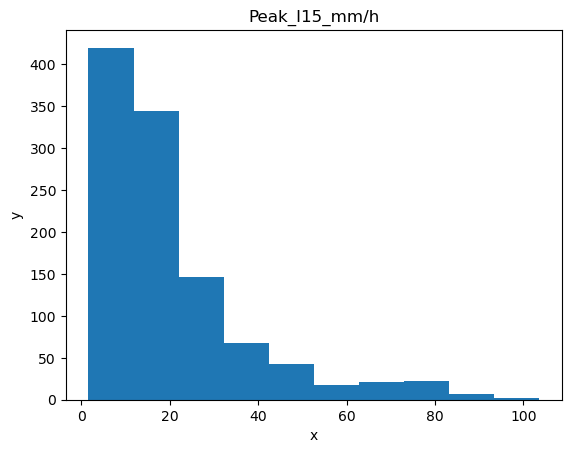

In [26]:
plt.hist(raw_data['Peak_I15_mm/h'], bins=10)
plt.title("Peak_I15_mm/h")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

### Using pandas (with matplotlib as backend)

In [27]:
# raw_data['Peak_I15_mm/h'].plot.hist()
# plt.title("Histogram of Peak_I15_mm/h")
# plt.xlabel("x")
# plt.ylabel("y")
# plt.show()

## Density Plot

### Using pandas/matplotlib

### Using seaborn

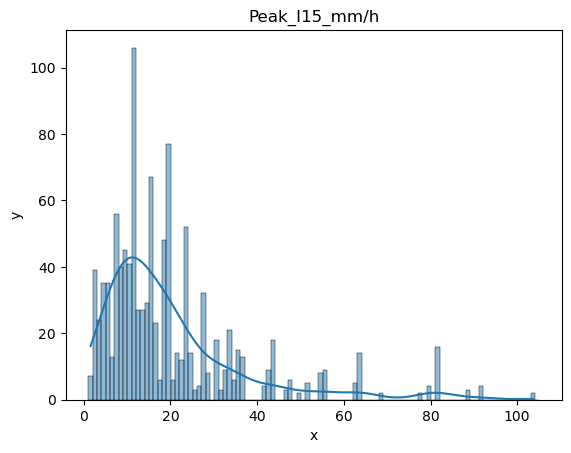

In [28]:
sns.histplot(raw_data['Peak_I15_mm/h'], kde=True, bins=30)
plt.title("Peak_I15_mm/h")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

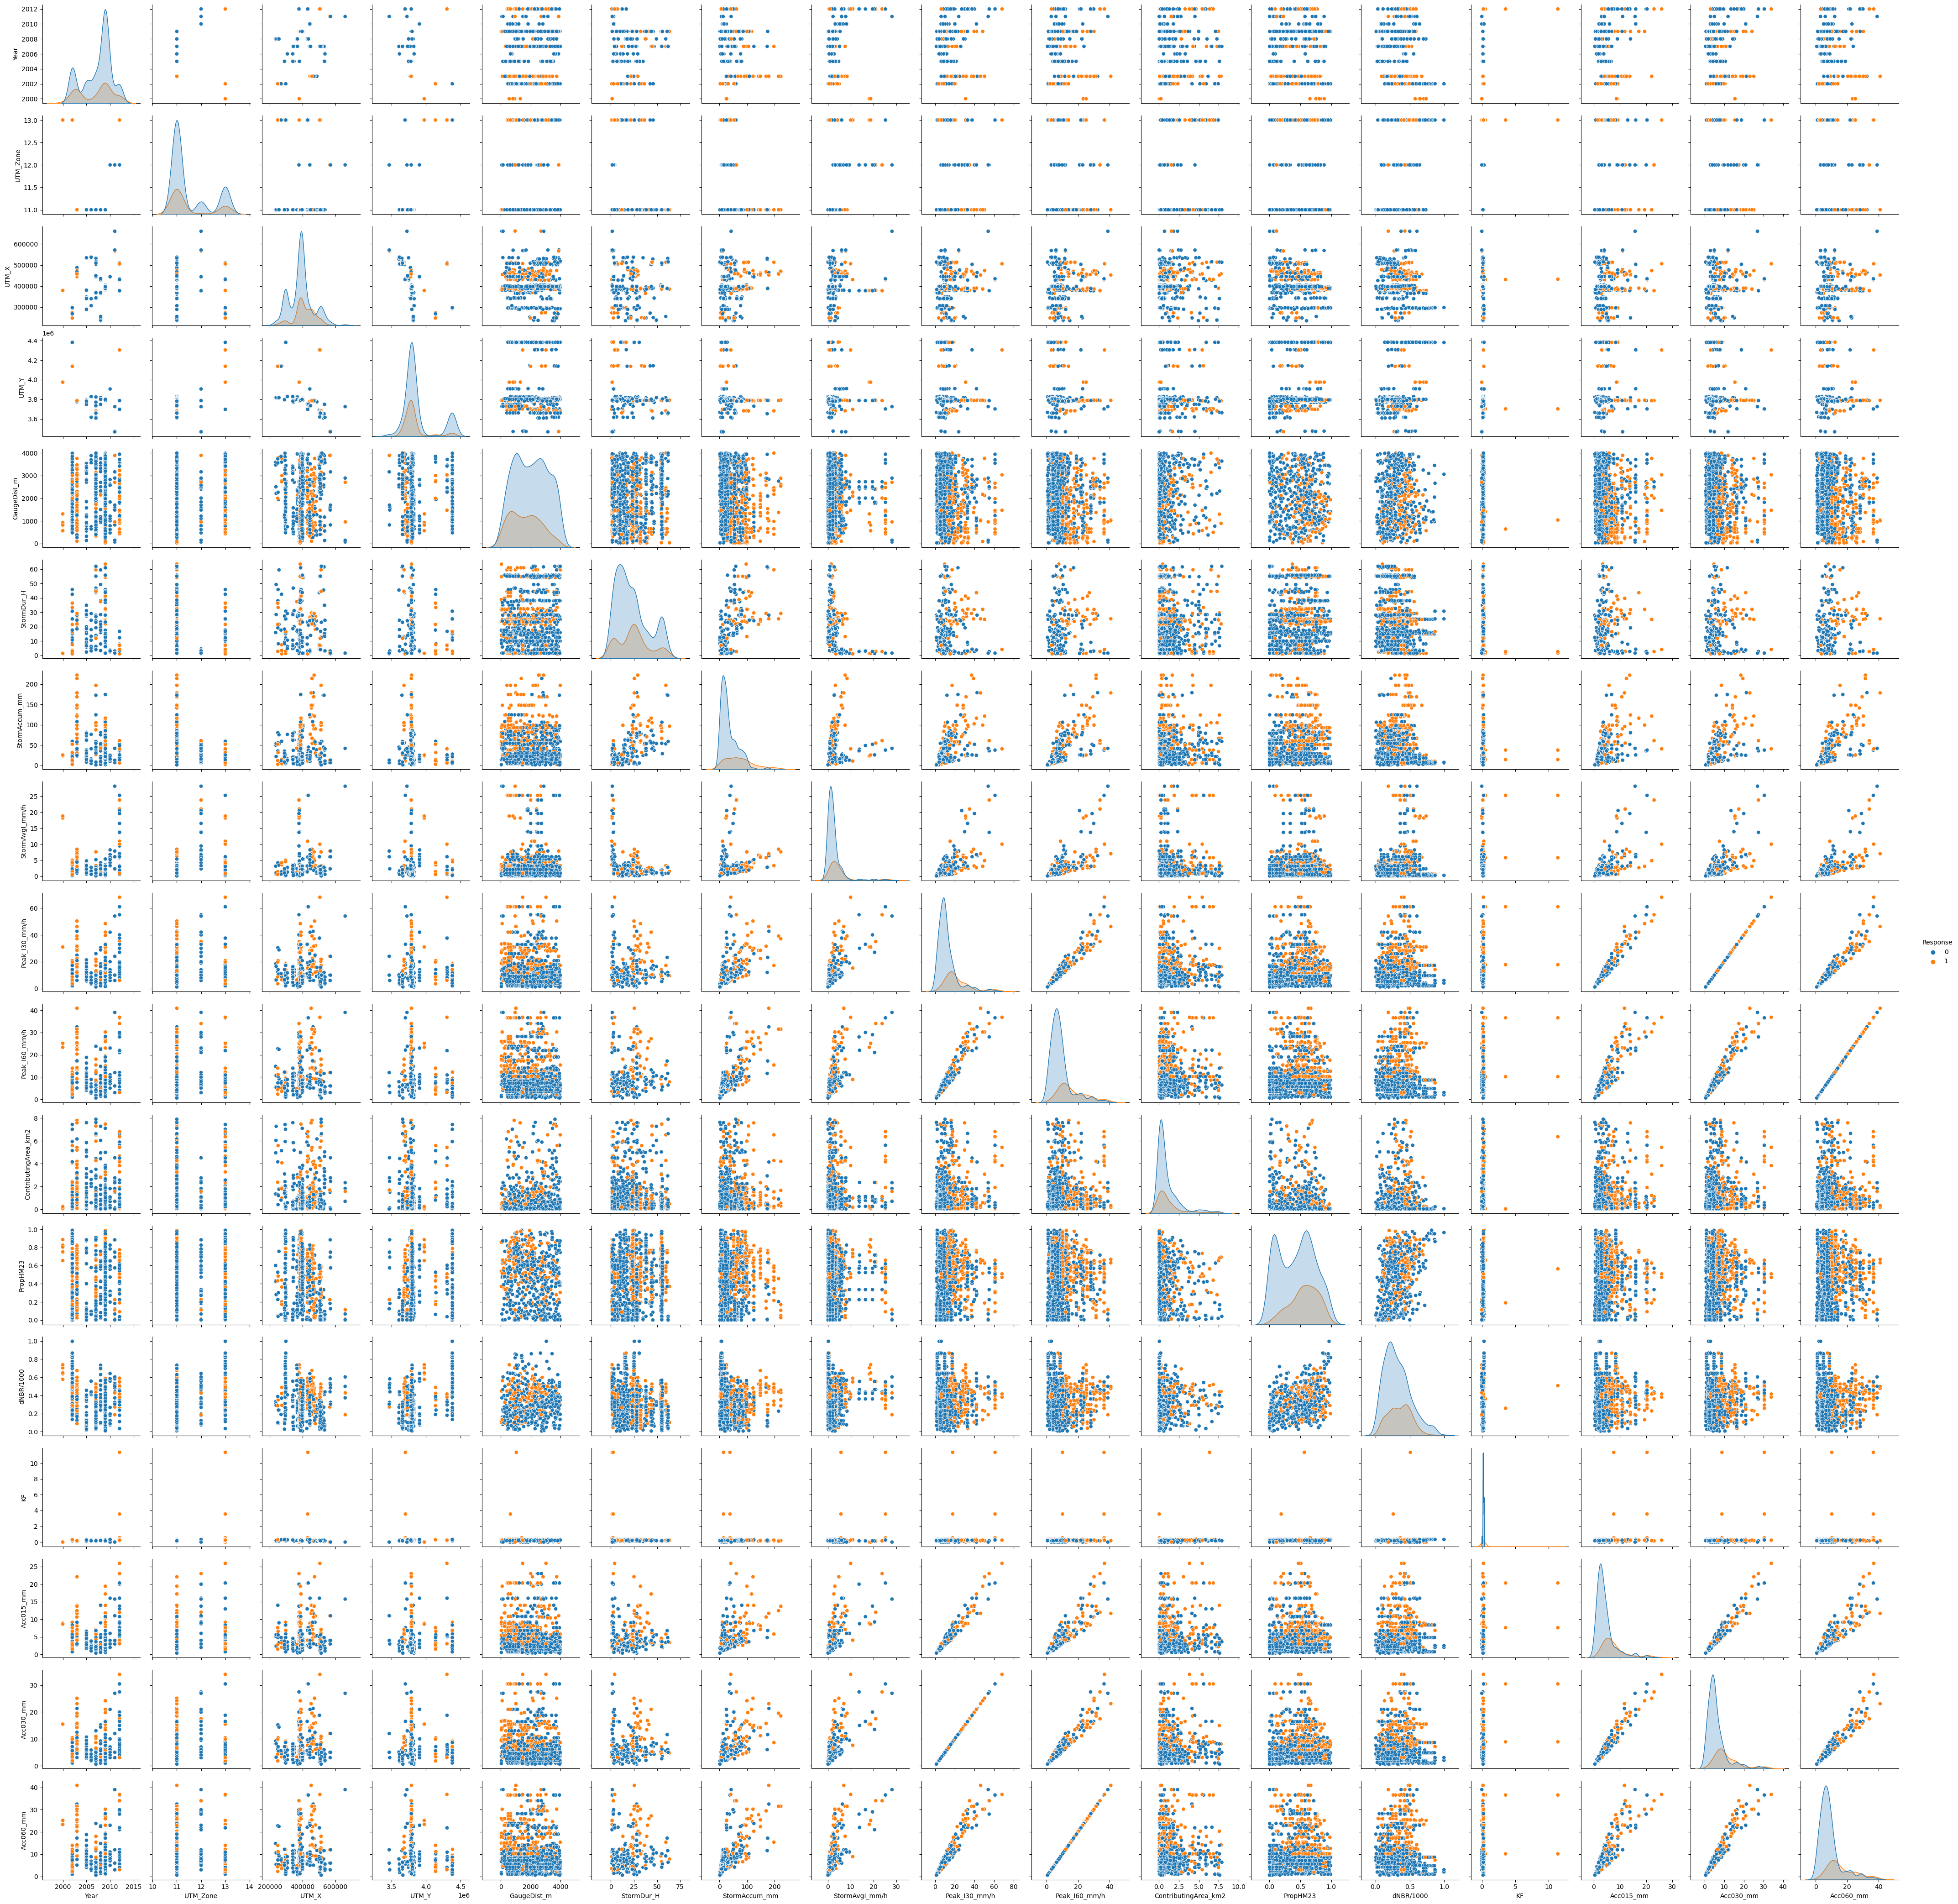

In [29]:
sns.pairplot(raw_data, hue='Response')

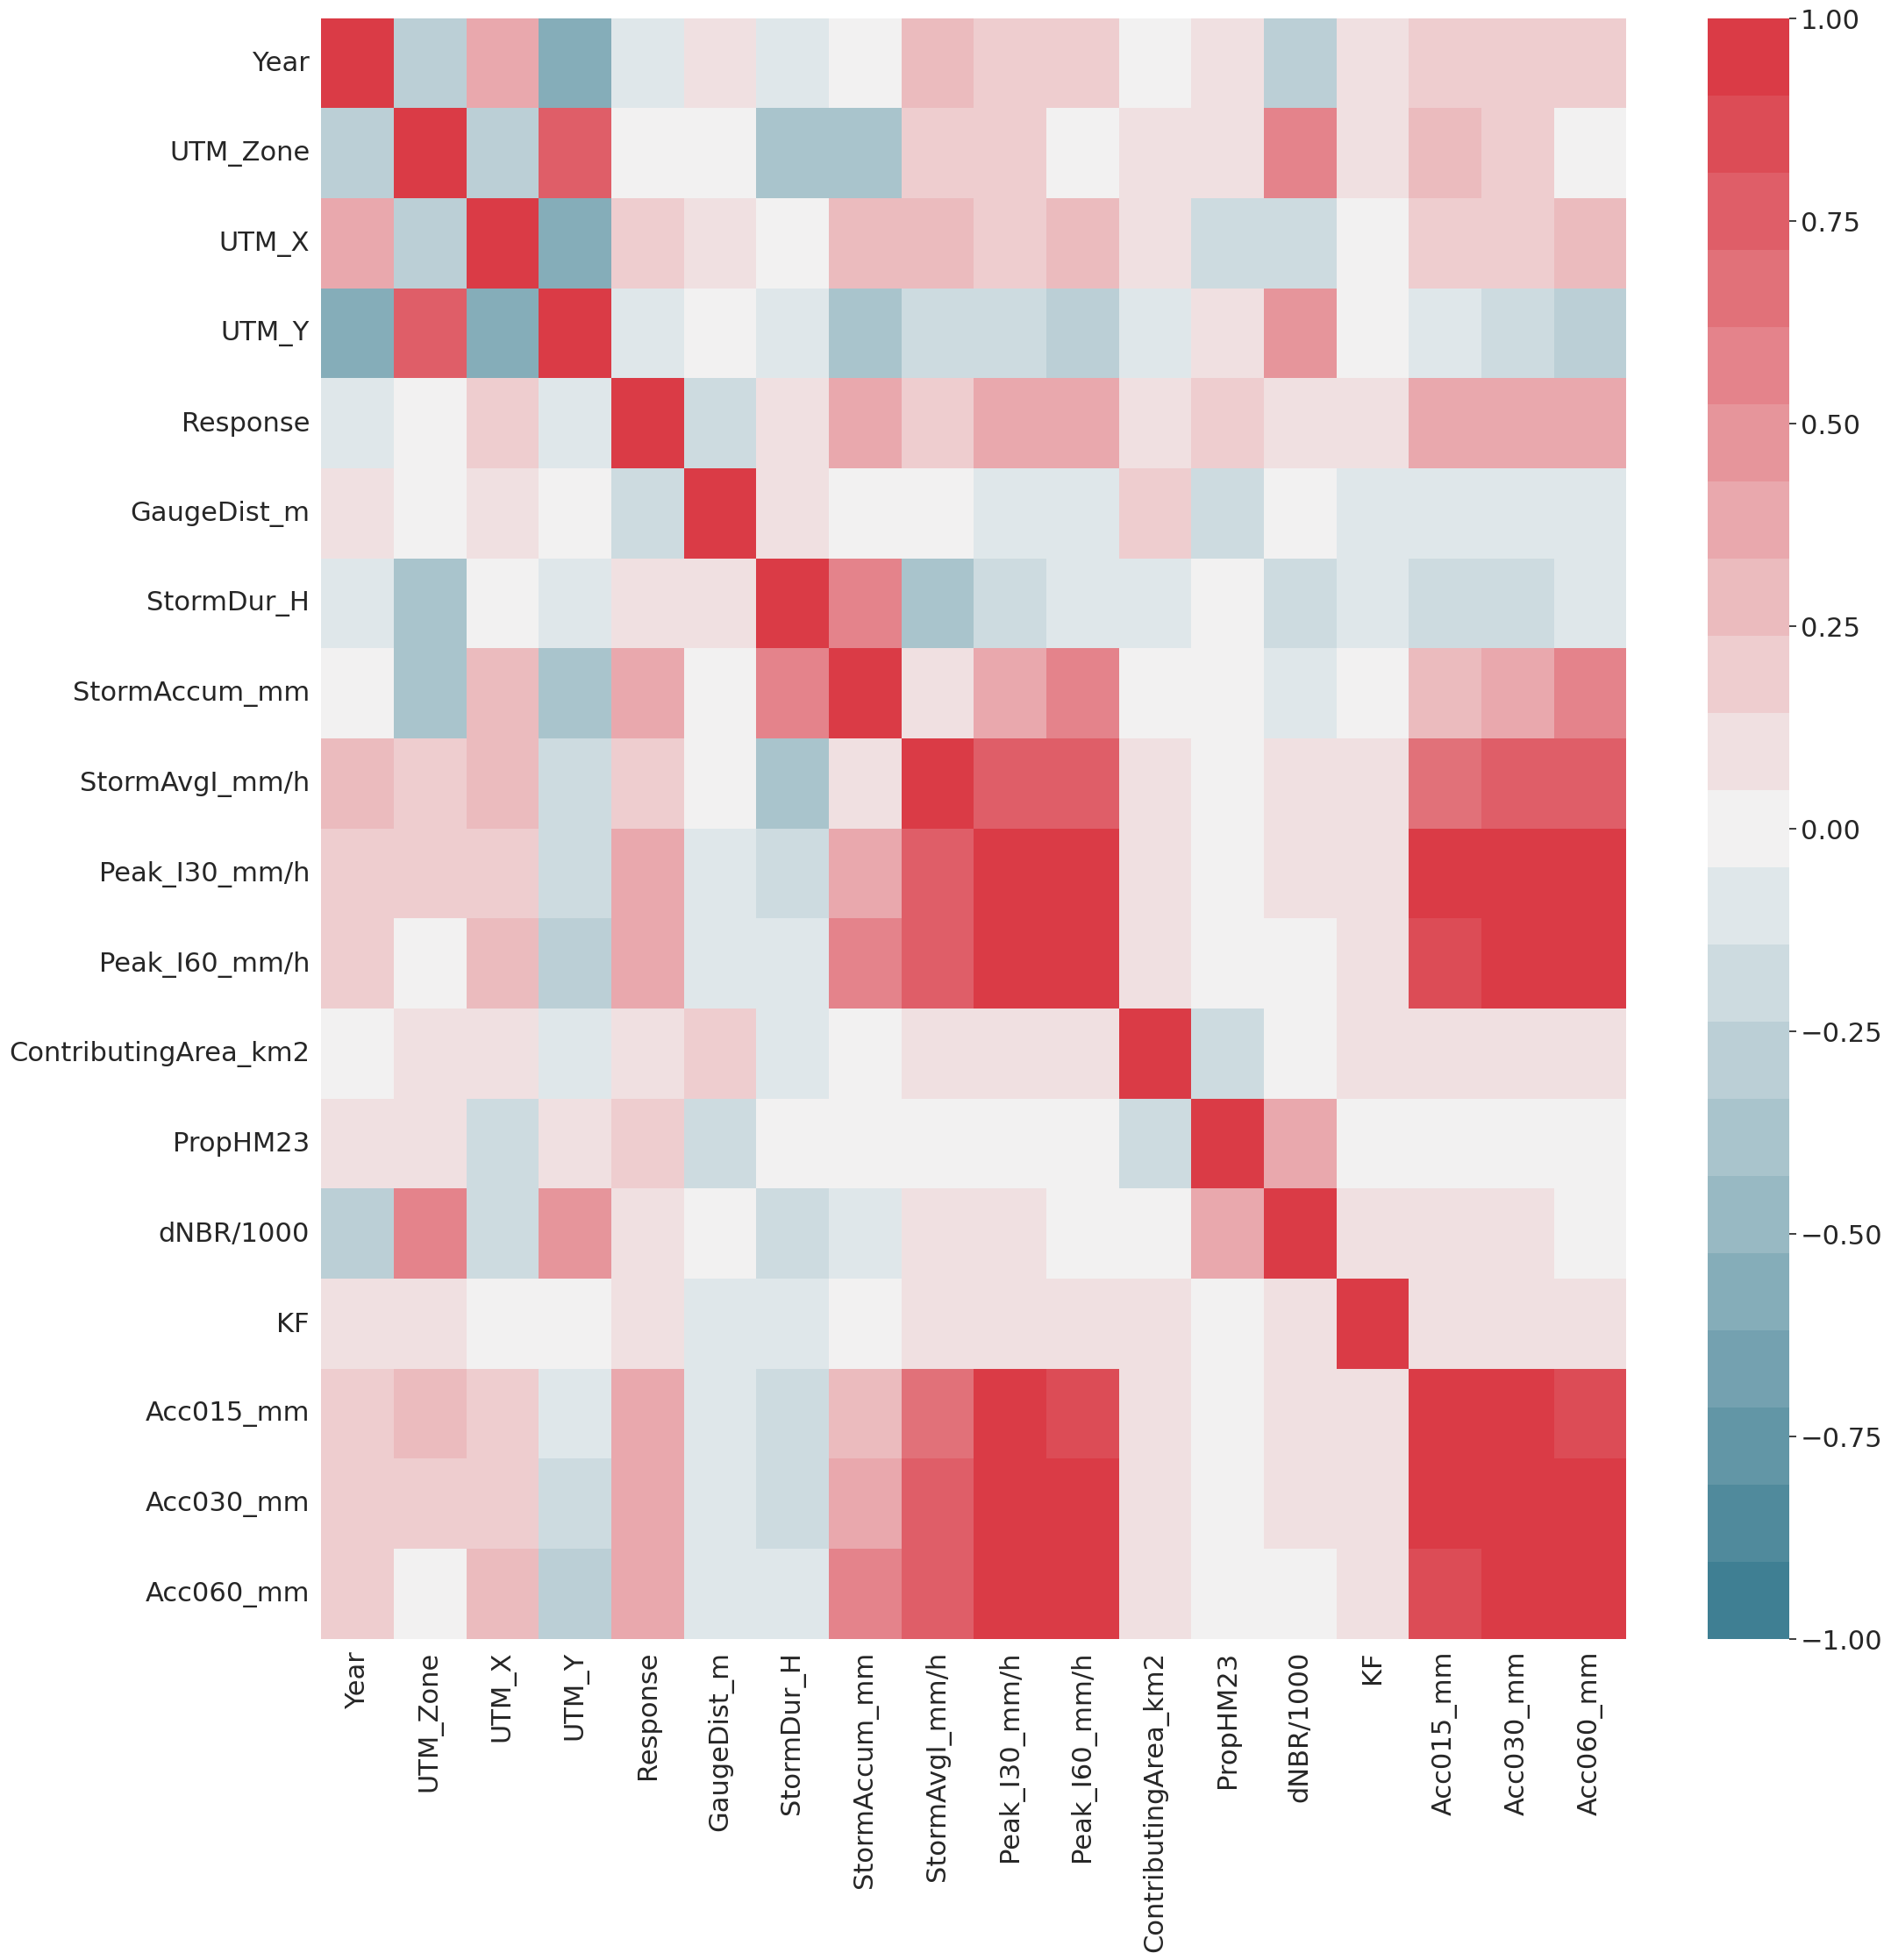

In [30]:
plt.figure(figsize=(24,24))
sns.set(font_scale=2)

sns.heatmap(raw_data.corr(),
           vmin=-1,
            vmax=1,
            cmap=sns.diverging_palette(220,10,n=21),       
           );

In [31]:
feat_cols = [
    'Peak_I15_mm/h'
    ,'PropHM23'
    ,'dNBR/1000'
    ,'KF'
]

target_col = 'Response'

model_data = raw_data[feat_cols + [target_col]]
model_data.head()

Peak_I15_mm/h  PropHM23  dNBR/1000        KF  Response
0           3.2  0.217933   0.297853  0.250000         0
1           3.2  0.061249   0.224896  0.250000         0
2           3.2  0.042968   0.065537  0.248541         0
3           1.6  0.092164   0.141711  0.250000         0
4           1.6  0.058353   0.210158  0.250000         0

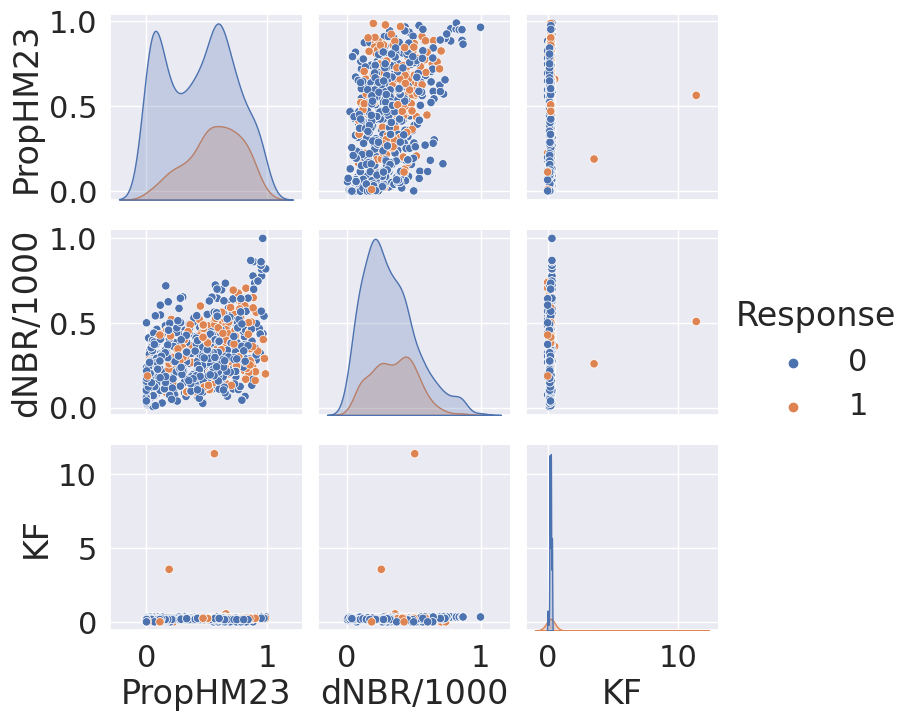

In [32]:
sns.pairplot(model_data, hue='Response')

## Bar plots for categorical features

### Using matplotlib

In [33]:
raw_data['Peak_I15_mm/h'].unique()

/opt/conda/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  output = repr(obj)


[3.20, 1.60, 9.14, 7.11, 4.00, ..., 68.800, 17.270, 64.008, 103.632, 63.000]
Length: 107
Categories (107, float64): [1.60, 2.40, 3.05, 3.20, ..., 81.280, 88.392, 92.000, 103.632]

### Using Seaborn

## Scatter Plot

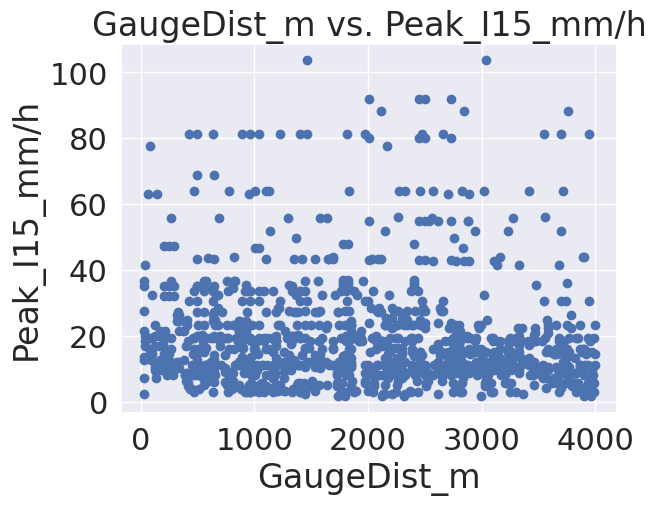

In [34]:
plt.scatter(x=raw_data['GaugeDist_m'], y=raw_data['Peak_I15_mm/h'])
plt.title('GaugeDist_m vs. Peak_I15_mm/h')
plt.xlabel('GaugeDist_m')
plt.ylabel('Peak_I15_mm/h')
plt.show()

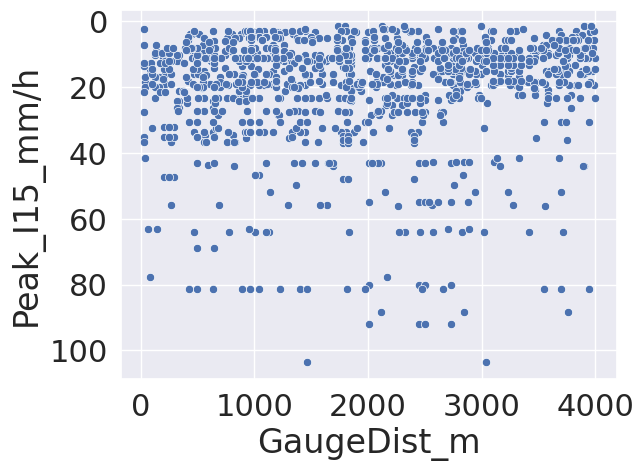

In [35]:
sns.scatterplot(x='GaugeDist_m', y='Peak_I15_mm/h', data=raw_data)
plt.show()

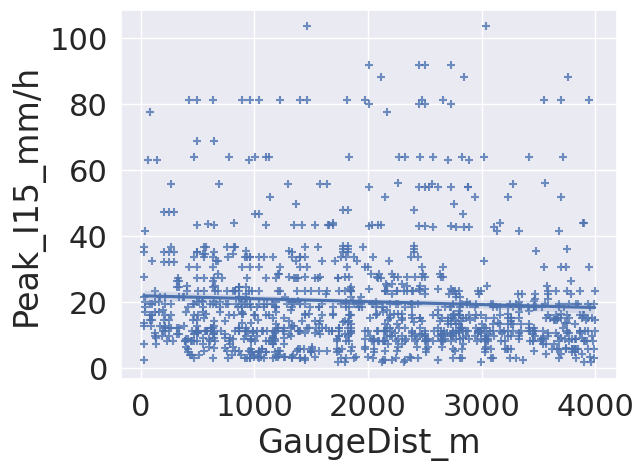

In [36]:
sns.regplot(x='GaugeDist_m', y='Peak_I15_mm/h', data=raw_data, marker='+')
plt.show()

## Line Plot

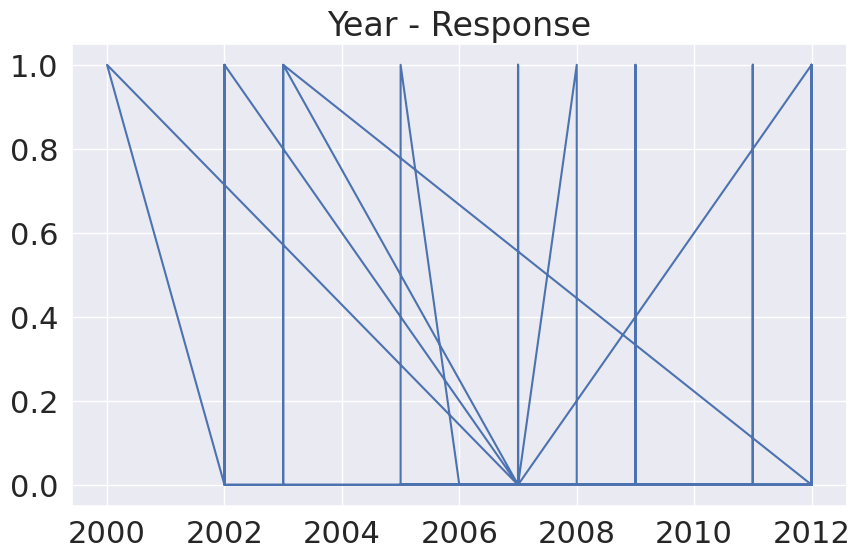

In [37]:
plt.figure(figsize=(10,6))
plt.plot(raw_data['Year'], raw_data['Response'])
plt.title('Year - Response')
plt.show()

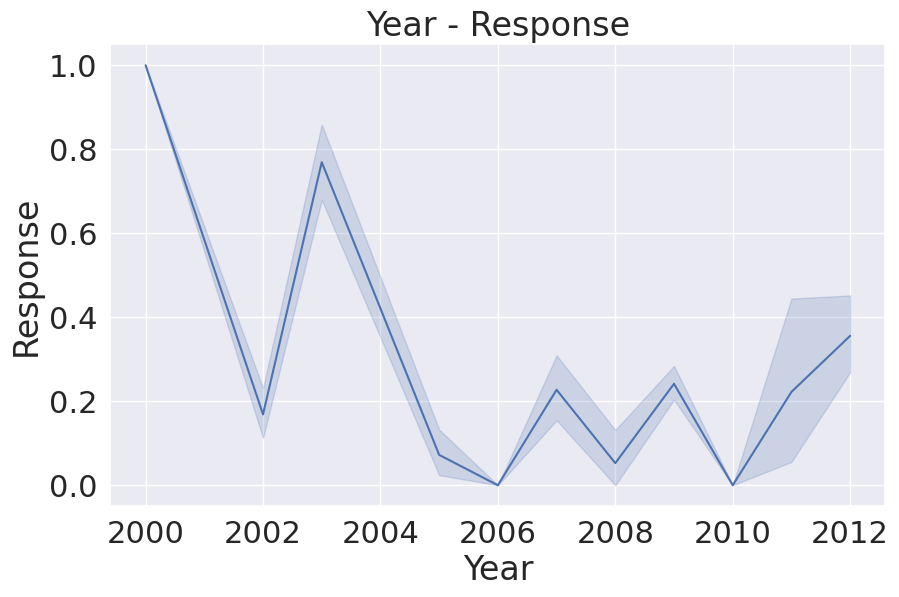

In [38]:
plt.figure(figsize=(10,6))
sns.lineplot(x='Year', y='Response', data=raw_data)
plt.title('Year - Response')
plt.show()

## Box Plot

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  grouped_vals = vals.groupby(grouper)


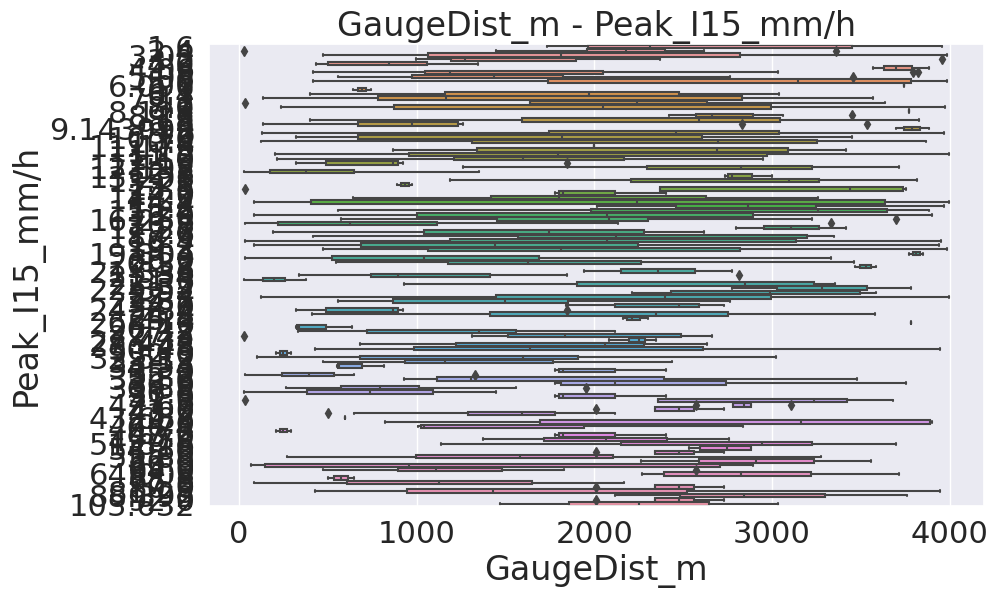

In [39]:
plt.figure(figsize=(10,6))
sns.boxplot(x='GaugeDist_m', y='Peak_I15_mm/h', data=raw_data)
plt.title('GaugeDist_m - Peak_I15_mm/h')
plt.show()

## Heat Map

# Logistic Regression <a id="LR">

The `ST16` model used only four features to predict the target variable:
- `i15`
- `PropHM23`
- `dNBR1000`
- `KF`
    - values should be less than 0.64, anything higher is not realistic and should probably be filtered out

and the target variable:
- `response`

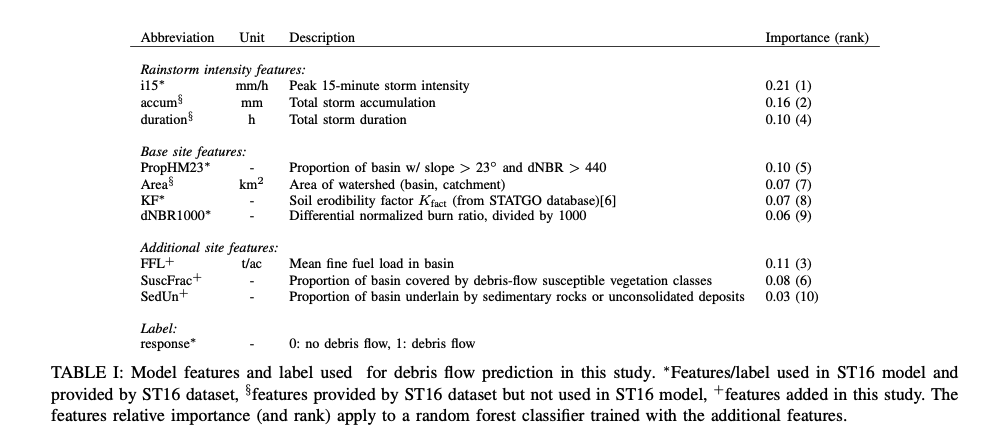

In [40]:
# double check with the data dictionary
dict_cols = data_dict.columns

data_dict.sort_values(by=dict_cols[0])

U.S. Geological Survey Open-File Report 2016-1106  \
28                                          Acc015_mm   
29                                          Acc030_mm   
30                                          Acc060_mm   
0   Appendix 1. Data supporting logistic regressio...   
3                                       Column Header   
24                               ContributingArea_km2   
8                                            Database   
4                                           Fire Name   
6                                             Fire_ID   
7                                          Fire_SegID   
15                                        GaugeDist_m   
27                                                 KF   
21                                      Peak_I15_mm/h   
22                                      Peak_I30_mm/h   
23                                      Peak_I60_mm/h   
25                                           PropHM23   
13                                           Response   
9                                               State   
19                                      StormAccum_mm   
20                                     StormAvgI_mm/h   
14                                          StormDate   
18                                         StormDur_H   
17                                           StormEnd   
16                                         StormStart   
11                                              UTM_X   
12                                              UTM_Y   
10                                           UTM_Zone   
5                                                Year   
1   [ID, identifier (in heading); UTM, Universal T...   
26                                          dNBR/1000   
2                                                 NaN   

                                           Unnamed: 1  
28  Peak 15-minute rainfall accumulation of storm,...  
29  Peak 30-minute rainfall accumulation of storm,...  
30  Peak 60-minute rainfall accumulation of storm,...  
0                                                 NaN  
3                                         Description  
24  Contributing area of observation location, in ...  
8   Database type: “Training” indicates data used ...  
4                                    Name of wildfire  
6                           Abbreviation of fire name  
7   Concatenated fire abbreviation and unique segm...  
15  Distance (in meters) from rain gauge to docume...  
27  Average KF-Factor (erodibility index of the fi...  
21  Peak 15-minute rainfall intensity of storm, in...  
22  Peak 30-minute rainfall intensity of storm, in...  
23  Peak 60-minute rainfall intensity of storm, in...  
25  Proportion of watershed burned at high or mode...  
13  Field-verified hydrologic response.  0 = no de...  
9                    State in which wildfire occurred  
19  Total rainfall accumulation of storm, in milli...  
20  Average storm intensity, in milllimeters per hour  
14  Date of storm that produced the debris-flow re...  
18                  Total duration of storm, in hours  
17  Date and time (24-hour format, GMT) that storm...  
16  Date and time (24-hour format, GMT) that storm...  
11  UTM X coordinate (Easting, in meters from zone...  
12  UTM Y coordinate (Northing, in meters from zon...  
10      UTM zone containing majority of wildfire area  
5                         Year of wildfire occurrence  
1                                                 NaN  
26  Average differenced normalized burn ratio (dNB...  
2                                                 NaN

In [41]:
feat_cols = [
    'Peak_I15_mm/h'
    ,'PropHM23'
    ,'dNBR/1000'
    ,'KF'
]

target_col = 'Response'

In [42]:
# split off the relevant data
# take a peak first to make sure it's good
raw_data[feat_cols + [target_col]]

Peak_I15_mm/h  PropHM23  dNBR/1000        KF  Response
0              3.2  0.217933   0.297853  0.250000         0
1              3.2  0.061249   0.224896  0.250000         0
2              3.2  0.042968   0.065537  0.248541         0
3              1.6  0.092164   0.141711  0.250000         0
4              1.6  0.058353   0.210158  0.250000         0
...            ...       ...        ...       ...       ...
1530          63.0  0.066777   0.373291  0.000000         0
1534          63.0  0.115890   0.604177  0.000000         0
1538          63.0  0.112607   0.428204  0.000000         1
1542          63.0  0.009801   0.187053  0.000000         1
1546          63.0  0.001571   0.500223  0.000000         0

[1091 rows x 5 columns]

The ST16 model only trained on Southern California, in this dataset all the California locations

In [43]:
raw_data.groupby('State')['Database'].value_counts().unstack().fillna(0).astype(int)

Database  Test  Training
State                   
AZ          84         0
CA           0       773
CO         182         0
NM          52         0

In [44]:
# split off just the CA data
st16_data = raw_data[raw_data['Database'] == 'Training']

# split the other sites as well
st16_test_data = raw_data[raw_data['Database'] == 'Test']

In [45]:
# not split the CA data to just our relevant columns
feat_data = st16_data[feat_cols]
target_data = st16_data[target_col]

In [46]:
# instantiate LR model

model = LogisticRegression()

In [47]:
# split training and test data
# ST16 may not even have done this
X_train, X_test, y_train, y_test = train_test_split(feat_data, 
                                                    target_data,
                                                    test_size=.10, # I'm not sure their test size, if any
                                                    random_state=seed
                                                   )

In [48]:
# just to double check :)
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

695
695
78
78


In [49]:
# fit the training data
fitted_model = model.fit(X_train, y_train)

# predict with the fitted model
y_pred = fitted_model.predict(X_test)

In [50]:
# confusion matrix for the binary y/n
confusion_matrix(y_test, y_pred)

array([[54,  4],
       [ 8, 12]])

In [51]:
# the predicted probabilities on the test data
# first value is no-debris-flow
# second value is yes-debris-flow

# can't directly compare this output to the target variable since that's a bool and these are probas no/yes
test_probas = fitted_model.predict_proba(X_test)
test_probas

array([[0.96103956, 0.03896044],
       [0.95166668, 0.04833332],
       [0.93784619, 0.06215381],
       [0.63721237, 0.36278763],
       [0.86527103, 0.13472897],
       [0.81170868, 0.18829132],
       [0.51977529, 0.48022471],
       [0.97591779, 0.02408221],
       [0.97315029, 0.02684971],
       [0.95362106, 0.04637894],
       [0.09703541, 0.90296459],
       [0.05240261, 0.94759739],
       [0.86909625, 0.13090375],
       [0.94700655, 0.05299345],
       [0.94559955, 0.05440045],
       [0.6250219 , 0.3749781 ],
       [0.6612036 , 0.3387964 ],
       [0.79643833, 0.20356167],
       [0.17143393, 0.82856607],
       [0.78680954, 0.21319046],
       [0.86088727, 0.13911273],
       [0.90384051, 0.09615949],
       [0.88552541, 0.11447459],
       [0.30188087, 0.69811913],
       [0.95288961, 0.04711039],
       [0.8578865 , 0.1421135 ],
       [0.70134811, 0.29865189],
       [0.59431432, 0.40568568],
       [0.98003942, 0.01996058],
       [0.06160543, 0.93839457],
       [0.

**ST16 reported a threat score of 0.42 on the training (Southern California) and 0.39 on the testing (remaining regions) sites**

In [52]:
# this model's threat score
# doesn't match up
pd.DataFrame(test_probas)[1].mean()

0.30310678154437276

How does our output compare to the ST16 parameters/weights?

I'm not understanding where the scalar values are coming from (besides the intercept -3.63)

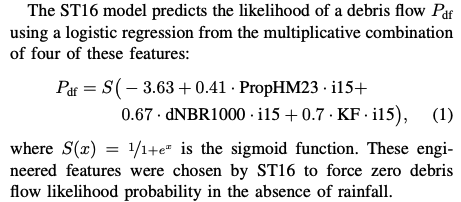

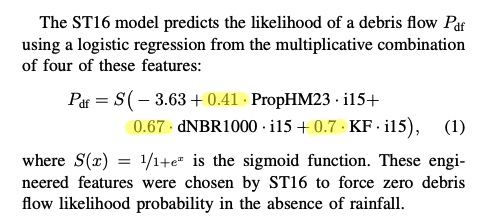

In [53]:
intercept = fitted_model.intercept_
intercept

array([-4.9397538])

In [54]:
# extract the model coefficients
weights = list(fitted_model.coef_[0])

In [55]:
for feat, weight in zip(feat_cols, weights):
    print(feat, ":", weight, "\n")

Peak_I15_mm/h : 0.12301137134521818 

PropHM23 : 2.334806292360513 

dNBR/1000 : 1.3339510600399445 

KF : 0.49177861148407237 



In [56]:
# logistic.cdf is the sigmoid function
# just an example number
logistic.cdf(1)

0.7310585786300049

In [57]:
X_test.head(3)

Peak_I15_mm/h  PropHM23  dNBR/1000        KF
1510           8.8  0.087871   0.267195  0.183413
1513           8.8  0.156905   0.323950  0.160000
1287           8.0  0.402351   0.171304  0.150000

In [58]:
# manually extract the probability using intercept, weights and values from some record
# this is predicted probability yes-debris-flow
logistic.cdf(intercept + sum(w * v for w, v in zip(weights, X_test.iloc[0,:].values)))

array([0.03896044])

In [59]:
# they match :)
test_probas[0][1]

0.038960443565588546

In [60]:
# again with another record
logistic.cdf(intercept + sum(w * v for w, v in zip(weights, X_test.iloc[1,:].values)))

array([0.04833332])

In [61]:
# again, they match :)
test_probas[1][1]

0.04833331942845121

In [62]:
# what's the predicted risk on the other sites?
st16_test_probas = fitted_model.predict_proba(st16_test_data[feat_cols])
pd.DataFrame(st16_test_probas)[1].mean()

0.4993233481259182